In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [3]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

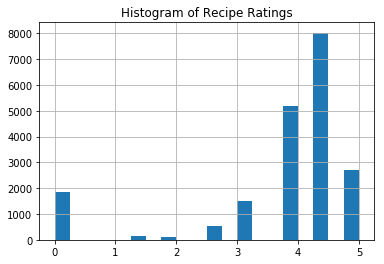

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [7]:
from sklearn.svm import SVR
svr = SVR(gamma='auto')
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

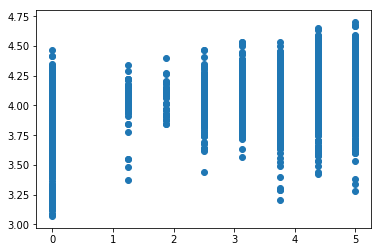

In [8]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinuous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [9]:
svr.score(X, Y)

-0.003978314483867651

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

In [11]:
raw_data['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

### Okay, let's start with the new, classifier-friendly version of rating.

I'm going to go the simple route and call everything with a rating >=4 'edible', with all other recipes deemed 'inedible'. This splits the dataset roughly in half: 10,738 recipes 'edible', 9,314 recipes 'inedible'.

Ideally we would know how many reviews are behind each rating so we could properly weight them--it doesn't feel fair to give a recipe with a 5 rating but only 3 reviews a pass, while a recipe with dozens of reviews and a 3.75 rating is left in the bin. 

In [12]:
raw_data['edible'] = raw_data['rating'].apply(lambda x: 1 if x >=4 else 0)

In [13]:
raw_data['edible'].value_counts()

1    10738
0     9314
Name: edible, dtype: int64

### And let's use a classifier, instead of a regression model. It helps.

In [31]:
#svr_edible = SVR(gamma='auto')
from sklearn.svm import SVC
svc_edible = SVC(gamma='auto')
X = raw_data.drop(['edible','rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data['edible'].sample(frac=0.3, replace=True, random_state=1)
svc_edible.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
svc_edible.score(X, Y)

0.5545212765957447

In [33]:
cross_val_score(svc_edible, X, Y, cv=5)

array([0.55647841, 0.54900332, 0.54779717, 0.54696592, 0.55407654])

In [34]:
recipe_corr = raw_data.corr()

In [35]:
recipe_corr['edible'].sort_values(ascending=False).head(30)

edible               1.000000
rating               0.655698
bon appétit          0.097076
roast                0.068198
thanksgiving         0.067094
peanut free          0.065897
soy free             0.065799
dinner               0.062186
christmas            0.054409
grill/barbecue       0.051204
tree nut free        0.047943
backyard bbq         0.047682
fall                 0.046565
grill                0.042924
stuffing/dressing    0.042454
goat cheese          0.041207
father's day         0.036564
dessert              0.036225
meat                 0.035801
fourth of july       0.033651
low carb             0.033458
turkey               0.033409
pork tenderloin      0.033370
cranberry            0.033333
sausage              0.031639
cake                 0.031405
brisket              0.031385
bake                 0.031329
red wine             0.031070
lamb                 0.030731
Name: edible, dtype: float64

In [36]:
most_negative_corr = recipe_corr.loc[recipe_corr['edible'] < -.03,'edible'].index.to_list()
most_negative_corr

['alcoholic',
 'bitters',
 'broccoli',
 'cocktail',
 'cocktail party',
 'drink',
 'gin',
 'gourmet',
 'harpercollins',
 'house & garden',
 'liqueur',
 'low fat',
 'pasta',
 'quick & easy',
 'radish',
 'rum',
 'scotch',
 'spirit',
 'stir-fry',
 'tofu',
 'vegan']

In [37]:
raw_data[most_negative_corr].describe()

,alcoholic,bitters,broccoli,cocktail,cocktail party,drink,gin,gourmet,harpercollins,house & garden,...,low fat,pasta,quick & easy,radish,rum,scotch,spirit,stir-fry,tofu,vegan
count,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.00000
mean,0.041642,0.006334,0.006084,0.018951,0.057550,0.054209,0.011271,0.331538,0.006034,0.022890,...,0.046330,0.048274,0.267903,0.010373,0.016507,0.001097,0.010922,0.011321,0.004588,0.09231
std,0.199774,0.079333,0.077765,0.136354,0.232897,0.226435,0.105566,0.470778,0.077448,0.149558,...,0.210203,0.214351,0.442878,0.101321,0.127418,0.033106,0.103937,0.105797,0.067581,0.28947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [38]:
recipe_corr.loc[recipe_corr['edible'].index != 'rating','edible']

calories                 0.012585
protein                  0.015498
fat                      0.012018
sodium                   0.012702
#cakeweek               -0.007013
#wasteless               0.006577
22-minute meals          0.016822
3-ingredient recipes    -0.025792
30 days of groceries     0.001346
advance prep required   -0.008663
alabama                 -0.004959
alaska                  -0.010724
alcoholic               -0.077158
almond                   0.023943
amaretto                 0.009340
anchovy                  0.001906
anise                   -0.008068
anniversary              0.004796
anthony bourdain        -0.010724
aperitif                -0.022186
appetizer                0.011202
apple                    0.009683
apple juice              0.004550
apricot                  0.012993
arizona                  0.003585
artichoke               -0.016010
arugula                  0.024055
asian pear              -0.011753
asparagus                0.007073
aspen         

In [39]:
most_positive_corr = recipe_corr.loc[(recipe_corr['edible'] > .02) & (recipe_corr['edible'].index != 'rating'),
                                     'edible'].index.to_list()
most_positive_corr

['almond',
 'arugula',
 'backyard bbq',
 'bacon',
 'bake',
 'beef',
 'beef rib',
 'beef tenderloin',
 'berry',
 'bon appétit',
 'braise',
 'brisket',
 'cake',
 'cheese',
 'christmas',
 'christmas eve',
 'cranberry',
 'cream cheese',
 'dessert',
 'dinner',
 'edible gift',
 'fall',
 'family reunion',
 "father's day",
 'feta',
 'fig',
 'fourth of july',
 'freeze/chill',
 'fruit',
 'goat cheese',
 'grill',
 'grill/barbecue',
 'ground lamb',
 'high fiber',
 'kidney friendly',
 'kosher',
 'lamb',
 'lamb chop',
 'low carb',
 'low cholesterol',
 'lunch',
 'marinate',
 'meat',
 'mixer',
 'molasses',
 'oscars',
 'pastry',
 'peanut free',
 'pecan',
 'pescatarian',
 'pomegranate',
 'pork',
 'pork tenderloin',
 'prune',
 'raisin',
 'red wine',
 'roast',
 'rosemary',
 'salmon',
 'sausage',
 'shallot',
 'shrimp',
 'soy free',
 'steak',
 'stuffing/dressing',
 'sweet potato/yam',
 'thanksgiving',
 'tree nut free',
 "valentine's day",
 'walnut',
 'turkey',
 'edible']

In [61]:
len(most_positive_corr)

72

In [48]:
highest_corr = most_positive_corr #+ most_negative_corr

In [49]:
highest_corr

['almond',
 'arugula',
 'backyard bbq',
 'bacon',
 'bake',
 'beef',
 'beef rib',
 'beef tenderloin',
 'berry',
 'bon appétit',
 'braise',
 'brisket',
 'cake',
 'cheese',
 'christmas',
 'christmas eve',
 'cranberry',
 'cream cheese',
 'dessert',
 'dinner',
 'edible gift',
 'fall',
 'family reunion',
 "father's day",
 'feta',
 'fig',
 'fourth of july',
 'freeze/chill',
 'fruit',
 'goat cheese',
 'grill',
 'grill/barbecue',
 'ground lamb',
 'high fiber',
 'kidney friendly',
 'kosher',
 'lamb',
 'lamb chop',
 'low carb',
 'low cholesterol',
 'lunch',
 'marinate',
 'meat',
 'mixer',
 'molasses',
 'oscars',
 'pastry',
 'peanut free',
 'pecan',
 'pescatarian',
 'pomegranate',
 'pork',
 'pork tenderloin',
 'prune',
 'raisin',
 'red wine',
 'roast',
 'rosemary',
 'salmon',
 'sausage',
 'shallot',
 'shrimp',
 'soy free',
 'steak',
 'stuffing/dressing',
 'sweet potato/yam',
 'thanksgiving',
 'tree nut free',
 "valentine's day",
 'walnut',
 'turkey',
 'edible']

In [62]:
len(highest_corr)

93

In [50]:
smaller_dataset = raw_data[highest_corr]

In [51]:
svc_small = SVC(gamma='auto')
X = smaller_dataset.drop(['edible'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = smaller_dataset['edible'].sample(frac=0.3, replace=True, random_state=1)
svc_small.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
svc_small.score(X, Y)

0.5847739361702128

In [53]:
cross_val_score(svc_small, X, Y, cv=5)

array([0.56312292, 0.56063123, 0.5677473 , 0.58603491, 0.58153078])

Same model, but with the extreme end of the negative corellations added to the mix.

In [54]:
highest_corr = most_positive_corr + most_negative_corr

In [55]:
smaller_dataset = raw_data[highest_corr]

In [56]:
svc_small = SVC(gamma='auto')
X = smaller_dataset.drop(['edible'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = smaller_dataset['edible'].sample(frac=0.3, replace=True, random_state=1)
svc_small.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
svc_small.score(X, Y)

0.5954122340425532

In [58]:
cross_val_score(svc_small, X, Y, cv=5)

array([0.58887043, 0.58222591, 0.57605985, 0.58852868, 0.57321131])

So I went from a completely awful regression model to a classifier that is at least 60% accurate. I'll take it.

This is still just under 100 features. I can try using fewer positively-correlated features, to see if I can get closer to the suggested goal of 30 features.

In [63]:
most_positive_corr = recipe_corr.loc[(recipe_corr['edible'] > .03) & (recipe_corr['edible'].index != 'rating'),
                                     'edible'].index.to_list()
len(most_positive_corr)

30

In [64]:
smallest_dataset = raw_data[most_positive_corr]
svc_smallest = SVC(gamma='auto')
X = smallest_dataset.drop(['edible'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = smallest_dataset['edible'].sample(frac=0.3, replace=True, random_state=1)
svc_smallest.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [65]:
svc_smallest.score(X, Y)

0.5733045212765957

In [66]:
cross_val_score(svc_smallest, X, Y, cv=5)

array([0.5448505 , 0.56063123, 0.56525353, 0.5752286 , 0.55740433])

Eh, still not bad.

## When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

__There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.__

__After all, people who eat chocolate _might_ just be happier people.__

* Holiday recipes are probably the biggest category of recipes with high ratings--Thanksgiving, Christmas, the 4th of July, and Father's Day in particular. I would also lump grilling/BBQ recipes in with this group.

* Specialty recipes (for those who must avoid peanuts/tree nuts/soy) rate highly. Low-carb recipes are also in the list of most highly-correlated features.

* Alcoholic beverages frequent the list of most negatively-correlated features. I didn't look to see whether this is because they lacked a rating (rating=0), but I can't imagine drinkers being this consistently _un_happy.